In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
import numpy as np
import pydot
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\Dan\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data
data= pd.read_csv('house_properties_data_processed.csv')

In [3]:
# drop the adress column
data.drop(columns='adress', inplace=True,axis=1)

# split the data into train, validation and test sets
train, test = train_test_split(data, test_size=0.2)
train, validation = train_test_split(train,test_size=0.2)

In [4]:
# split the data into features and labels and scale it to be between 0 and 1 using the max value
data_features = train.copy()

data_scaling = max(data['sold_price'])
data_labels = data_features.pop('sold_price')/ data_scaling

validation_features = validation.copy()
validation_labels = validation.pop('sold_price')/ data_scaling

In [5]:
# input dictionary for the input layer taken from the data features
inputs = {name: tf.keras.layers.Input(shape=(1,), name=name) for name in data_features.keys()}

In [6]:
inputs

{'longitude': <tf.Tensor 'longitude:0' shape=(None, 1) dtype=float32>,
 'latitude': <tf.Tensor 'latitude:0' shape=(None, 1) dtype=float32>,
 'living_area': <tf.Tensor 'living_area:0' shape=(None, 1) dtype=float32>,
 'land_area': <tf.Tensor 'land_area:0' shape=(None, 1) dtype=float32>,
 'supplemental_area': <tf.Tensor 'supplemental_area:0' shape=(None, 1) dtype=float32>,
 'patio': <tf.Tensor 'patio:0' shape=(None, 1) dtype=float32>,
 'balcony': <tf.Tensor 'balcony:0' shape=(None, 1) dtype=float32>,
 'number_of_rooms': <tf.Tensor 'number_of_rooms:0' shape=(None, 1) dtype=float32>,
 'build_year': <tf.Tensor 'build_year:0' shape=(None, 1) dtype=float32>,
 'operating_cost': <tf.Tensor 'operating_cost:0' shape=(None, 1) dtype=float32>,
 'living_to_land_ratio': <tf.Tensor 'living_to_land_ratio:0' shape=(None, 1) dtype=float32>,
 'area_per_room': <tf.Tensor 'area_per_room:0' shape=(None, 1) dtype=float32>}

In [7]:
# concatenate the inputs into a tensor
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization/truediv:0' shape=(None, 12) dtype=float32>

In [8]:
preprocessed_inputs = [all_numeric_inputs]

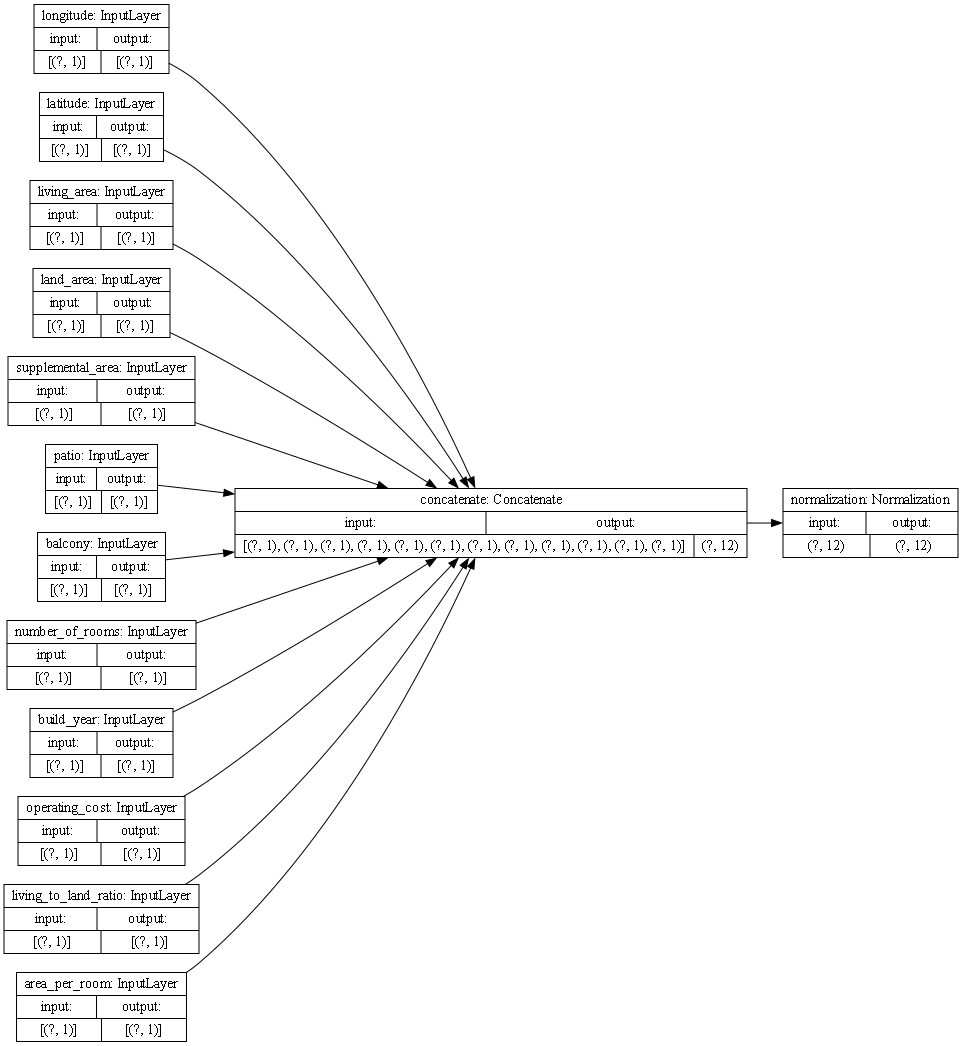

In [9]:
# model that preprocesses the data
housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [10]:
# create a dictionary of tensors for the categorical inputs
data_features_dict = {name: np.array(value) 
                         for name, value in data_features.items()}

In [11]:
data_dict = {name:values[:1] for name, values in data_features_dict.items()}
housePrices_preprocessing(data_dict)

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 1.4284565 ,  0.82148796, -0.04338787, -0.15057983, -0.10565491,
        -0.5721347 , -0.29567945, -0.06555099,  0.1926729 , -0.85296476,
        -0.17193684, -0.04390555]], dtype=float32)>

In [12]:
# define the model architecture and compile it
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

In [13]:
# train the model using data features and labels and validate it using the validation set
validation_features_dict = {name: np.array(value) 
                         for name, value in validation.items()}
history_1 = housePrices_model.fit(x=data_features_dict, y=data_labels,epochs=250,
                        validation_data=(validation_features_dict, validation_labels))

Epoch 1/250
45/45 [==============================] - 0s 4ms/step - loss: 0.0333 - mae: 0.0782 - val_loss: 0.0275 - val_mae: 0.0635
Epoch 2/250
45/45 [==============================] - 0s 1ms/step - loss: 0.0237 - mae: 0.0503 - val_loss: 0.0228 - val_mae: 0.0530
Epoch 3/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0200 - mae: 0.0428 - val_loss: 0.0207 - val_mae: 0.0511
Epoch 4/250
45/45 [==============================] - 0s 1ms/step - loss: 0.0176 - mae: 0.0397 - val_loss: 0.0185 - val_mae: 0.0493
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0154 - mae: 0.0369 - val_loss: 0.0169 - val_mae: 0.0483
Epoch 6/250
45/45 [==============================] - 0s 882us/step - loss: 0.0136 - mae: 0.0362 - val_loss: 0.0156 - val_mae: 0.0482
Epoch 7/250
45/45 [==============================] - 0s 871us/step - loss: 0.0121 - mae: 0.0353 - val_loss: 0.0137 - val_mae: 0.0462
Epoch 8/250
45/45 [==============================] - 0s 860us/step - loss: 0.01

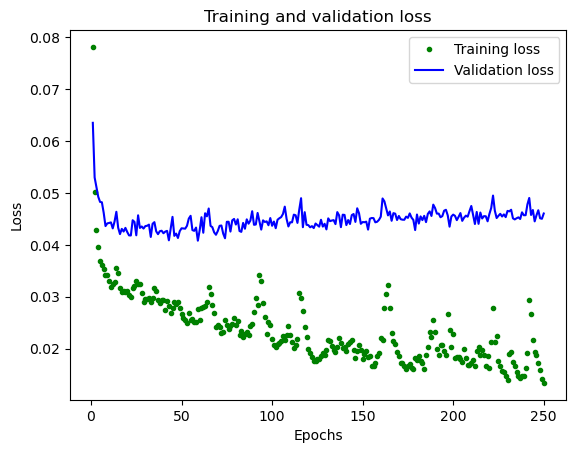

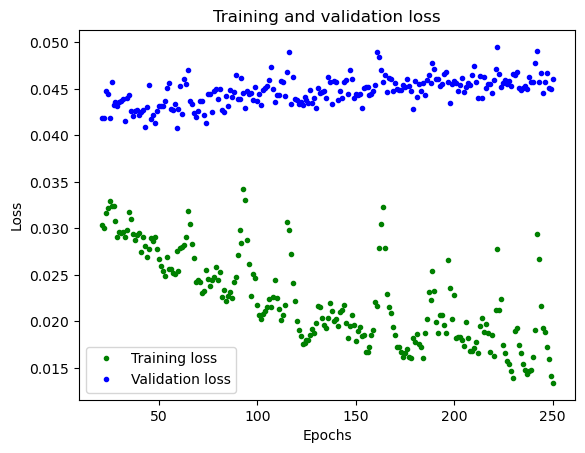

In [20]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
validation_loss = history_1.history['val_mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], validation_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# save model and load it
housePrices_model.save('House_prices_model')
reloaded = tf.keras.models.load_model('House_prices_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: House_prices_model\assets


In [16]:
# create a dictionary of features for the test set
test_features_dict = {name: np.array(value) 
                         for name, value in test.items()}

#predict the price of the test set
predicted_price_test_set = reloaded.predict(test_features_dict)*data_scaling

test_with_result = test.copy()
test_with_result['predicted_price'] = predicted_price_test_set

c:\Users\Dan\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\tensorflow\python\keras\engine\functional.py:540: UserWarning: Input dict contained keys ['sold_price'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


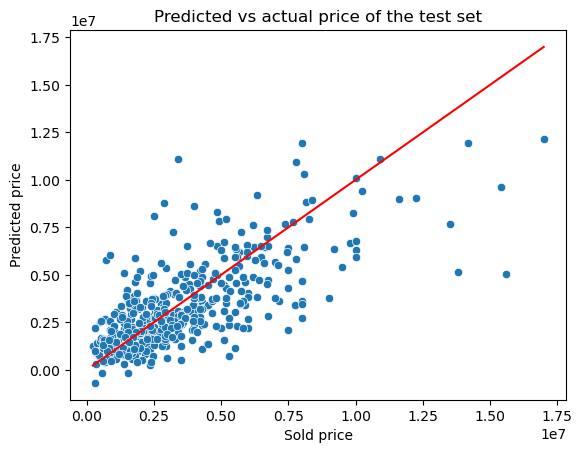

In [17]:
# scatterplot of the predicted and actual prices of the test set, red line is the line of equality
sns.scatterplot(x = test_with_result['sold_price'], y = test_with_result['predicted_price'])
sns.lineplot(x = test_with_result['sold_price'], y = test_with_result['sold_price'],dashes=True, color='red')

plt.xlabel('Sold price')
plt.ylabel('Predicted price')
plt.title('Predicted vs actual price of the test set')

plt.show()

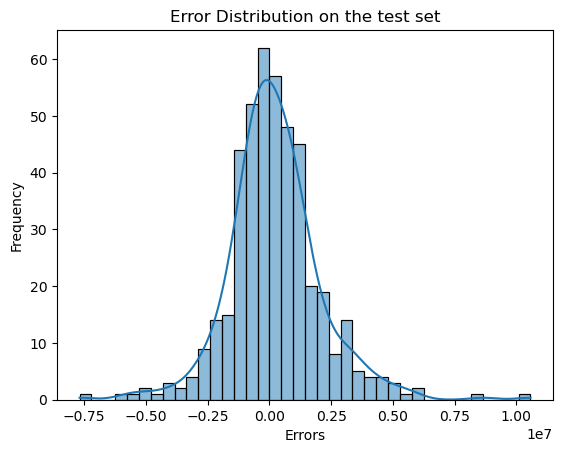

In [18]:
# calculate the errors
errors = test_with_result['sold_price'] - test_with_result['predicted_price']

# Create the histogram
sns.histplot(errors, kde=True)

# Add labels and a title
plt.xlabel('Errors')
plt.ylabel('Frequency')
plt.title('Error Distribution on the test set')

# Show the plot
plt.show()

In [19]:
# Compute the t-test statistic and p-value
t_stat, p_value = ttest_ind(test_with_result['predicted_price'], test_with_result['sold_price'])

# Check if the p-value is less than 0.05 (95% confidence level)
if p_value < 0.05:
    print("The model performance is statistically significant.")
else:
    print("The model performance is not statistically significant.")


The model performance is not statistically significant.
